In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
sys.path.append('./src') 
from preprocessor import load_and_preprocess, reverse_preprocessing, scale
from tqdm import tqdm
import torch
import qwen
from torch.utils.data import DataLoader, TensorDataset
import os
import FLOPS
from qwen_tools import generate_predictions, convert_tokens, tot_mse, mse

In [2]:
with h5py.File("lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:] # Shape: (n_systems, n_time_points, n_species)
    time_points = f["time"][:]
    # Access a single trajectory
    system_id = 0 # First system
    # All 100 time points:
    prey_0 = trajectories[0, :, 0]
    predator_0 = trajectories[0, :, 1]
    times = time_points[:]

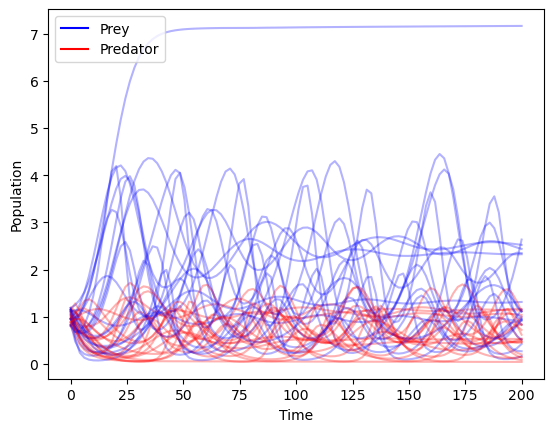

In [3]:
for sys in range(20):
    prey = trajectories[sys, :, 0]
    predator = trajectories[sys, :, 1]
    plt.plot(times, prey, alpha=0.3, c='b')
    plt.plot(times, predator , alpha=0.3, c='r')

plt.xlabel("Time")
plt.ylabel("Population")

plt.plot([], [], label="Prey", c='b')  
plt.plot([], [], label="Predator", c='r')  
plt.legend()

# Preprocessing

In [4]:
# torch.cuda.empty_cache() 
model, tokenizer = qwen.load_qwen()
torch.mps.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
model.to(device)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Device: cpu


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

Maximum value in scaled_trajectories: 3.983


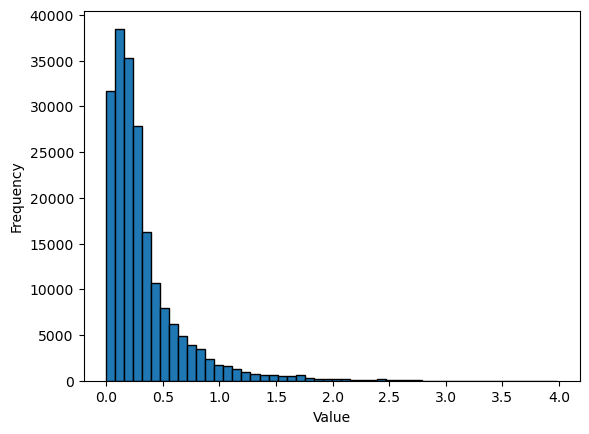

In [5]:
scaled_trajectories , norm_factor = scale(trajectories, 3)

# Print the maximum value in the scaled_trajectories array
max_value = np.max(scaled_trajectories)
print("Maximum value in scaled_trajectories:", max_value)

flattened_trajectories = scaled_trajectories.flatten()

# Plot a histogram of the values
plt.hist(flattened_trajectories, bins=50, edgecolor='black') 
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.savefig('plots/scaled_distribution.png', dpi=300)
plt.show()



In [6]:
train_data , val_data ,test_data, norm_factor= load_and_preprocess('lotka_volterra_data.h5')
print(np.shape(train_data))  # First 800 systems
print(np.shape(val_data)) 
print(np.shape(test_data)) 
print('Normalisation factor', norm_factor)

(800,)
(100,)
(100,)
Normalisation factor 3.4500234


In [7]:
# Transform the data into PyTorch tensors
tokenised_train = [
    tokenizer(train_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(train_data)[0]) ]

tokenised_val = [
    tokenizer(val_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(val_data)[0]) ]

tokenised_test = [
    tokenizer(test_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(test_data)[0]) ]

In [8]:
for sys_id in range(2):  # Loop through the first two systems (0 and 1)
    print(f"--- System {sys_id} ---")
    print(f"Preprocessed: {train_data[sys_id]}")
    print(f"Tokenised: {tokenised_train[sys_id]}")
    print('----------------------------------')


--- System 0 ---
Preprocessed: 0.275,0.302;0.215,0.226;0.198,0.164;0.208,0.118;0.239,0.087;0.291,0.067;0.366,0.054;0.465,0.047;0.589,0.045;0.731,0.047;0.881,0.054;1.020,0.069;1.120,0.093;1.153,0.131;1.094,0.183;0.944,0.240;0.739,0.284;0.546,0.294;0.408,0.269;0.331,0.225;0.299,0.179;0.298,0.141;0.321,0.113;0.366,0.092;0.430,0.079;0.513,0.072;0.611,0.071;0.718,0.074;0.822,0.084;0.905,0.101;0.951,0.126;0.943,0.159;0.875,0.196;0.761,0.228;0.630,0.246;0.514,0.242;0.432,0.220;0.386,0.191;0.370,0.161;0.378,0.135;0.406,0.116;0.452,0.102;0.513,0.094;0.585,0.091;0.663,0.093;0.738,0.100;0.798,0.113;0.833,0.131;0.833,0.155;0.794,0.180;0.723,0.202;0.637,0.215;0.555,0.215;0.489,0.204;0.447,0.185;0.428,0.164;0.429,0.144;0.448,0.128;0.483,0.116;0.529,0.109;0.583,0.106;0.641,0.107;0.695,0.113;0.738,0.124;0.761,0.138;0.761,0.155;0.734,0.172;0.686,0.187;0.628,0.196;0.569,0.197;0.520,0.190;0.486,0.177;0.469,0.162;0.469,0.148;0.483,0.135;0.509,0.125;0.545,0.119;0.587,0.117;0.630,0.118;0.670,0.123;0.700,0.1

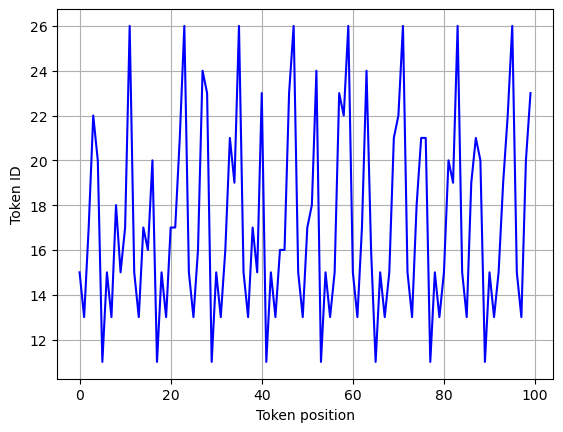

In [9]:
plt.plot(tokenised_train[0][:100], label="Prey", c='b')
plt.xlabel("Token position")
plt.ylabel("Token ID")
plt.grid()

# Untrained model

In [10]:
# Stack the tokenised sequences into a single tensor
tokenised_tensors_train = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_train])
tokenised_tensors_val = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_val])
tokenised_tensors_test = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_test])
print(tokenised_tensors_train.shape)
print(tokenised_tensors_val.shape)
print(tokenised_tensors_test.shape)


torch.Size([800, 1199])
torch.Size([100, 1199])
torch.Size([100, 1199])


In [11]:
# Generate predictions for the test data
predicted_tokens = generate_predictions(test_data, model, tokenizer, device, decimal_places=3)
predicted_prey, predicted_predator = convert_tokens(predicted_tokens, tokenizer)

Generating Tokens:   0%|          | 0/6 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Generating Tokens:   0%|          | 0/6 [02:23<?, ?it/s]


KeyboardInterrupt: 

In [18]:
training_token_id = 80*12 # The token ID at which the training data ends
print('Target tokens:', tokenised_tensors_test[0, training_token_id:training_token_id + 40])
print('Predicted tokens:', predicted_tokens[0,0, training_token_id:training_token_id + 40])

Target tokens: tensor([15, 13, 17, 18, 15, 11, 15, 13, 16, 16, 19, 26, 15, 13, 17, 20, 21, 11,
        15, 13, 16, 18, 24, 26, 15, 13, 17, 21, 18, 11, 15, 13, 16, 22, 18, 26,
        15, 13, 17, 19])
Predicted tokens: tensor([15, 13, 17, 18, 17, 11, 15, 13, 16, 16, 17, 26, 15, 13, 17, 21, 19, 11,
        15, 13, 16, 18, 19, 26, 15, 13, 17, 24, 21, 11, 15, 13, 16, 21, 15, 26,
        15, 13, 17, 24])


In [21]:
if not os.path.exists('results'):
    os.makedirs('results')
    print(f"Created folder: results")
np.save('results/qwen_predicted_prey.npy', predicted_prey)
np.save('results/qwen_predicted_predator.npy', predicted_predator)

# Count NaN values in predicted_prey
nan_prey = np.sum(np.isnan(predicted_prey))

# Count NaN values in predicted_predator
nan_predator = np.sum(np.isnan(predicted_predator))

print(f"Number of NaN values in predicted_prey: {nan_prey}")
print(f"Number of NaN values in predicted_predator: {nan_predator}")

Number of NaN values in predicted_prey: 0
Number of NaN values in predicted_predator: 0


In [22]:
qwen_predicted_prey = np.load('results/qwen_predicted_prey.npy')
qwen_predicted_predator = np.load('results/qwen_predicted_predator.npy')

System 1: Prey MSE = 0.001, Predator MSE = 0.000
System 2: Prey MSE = 0.007, Predator MSE = 0.009
System 3: Prey MSE = 0.043, Predator MSE = 0.001
System 4: Prey MSE = 0.277, Predator MSE = 0.001
System 5: Prey MSE = 0.004, Predator MSE = 0.001
System 6: Prey MSE = 0.014, Predator MSE = 0.008
Total MSE for prey: 0.347
Total MSE for predator: 0.020


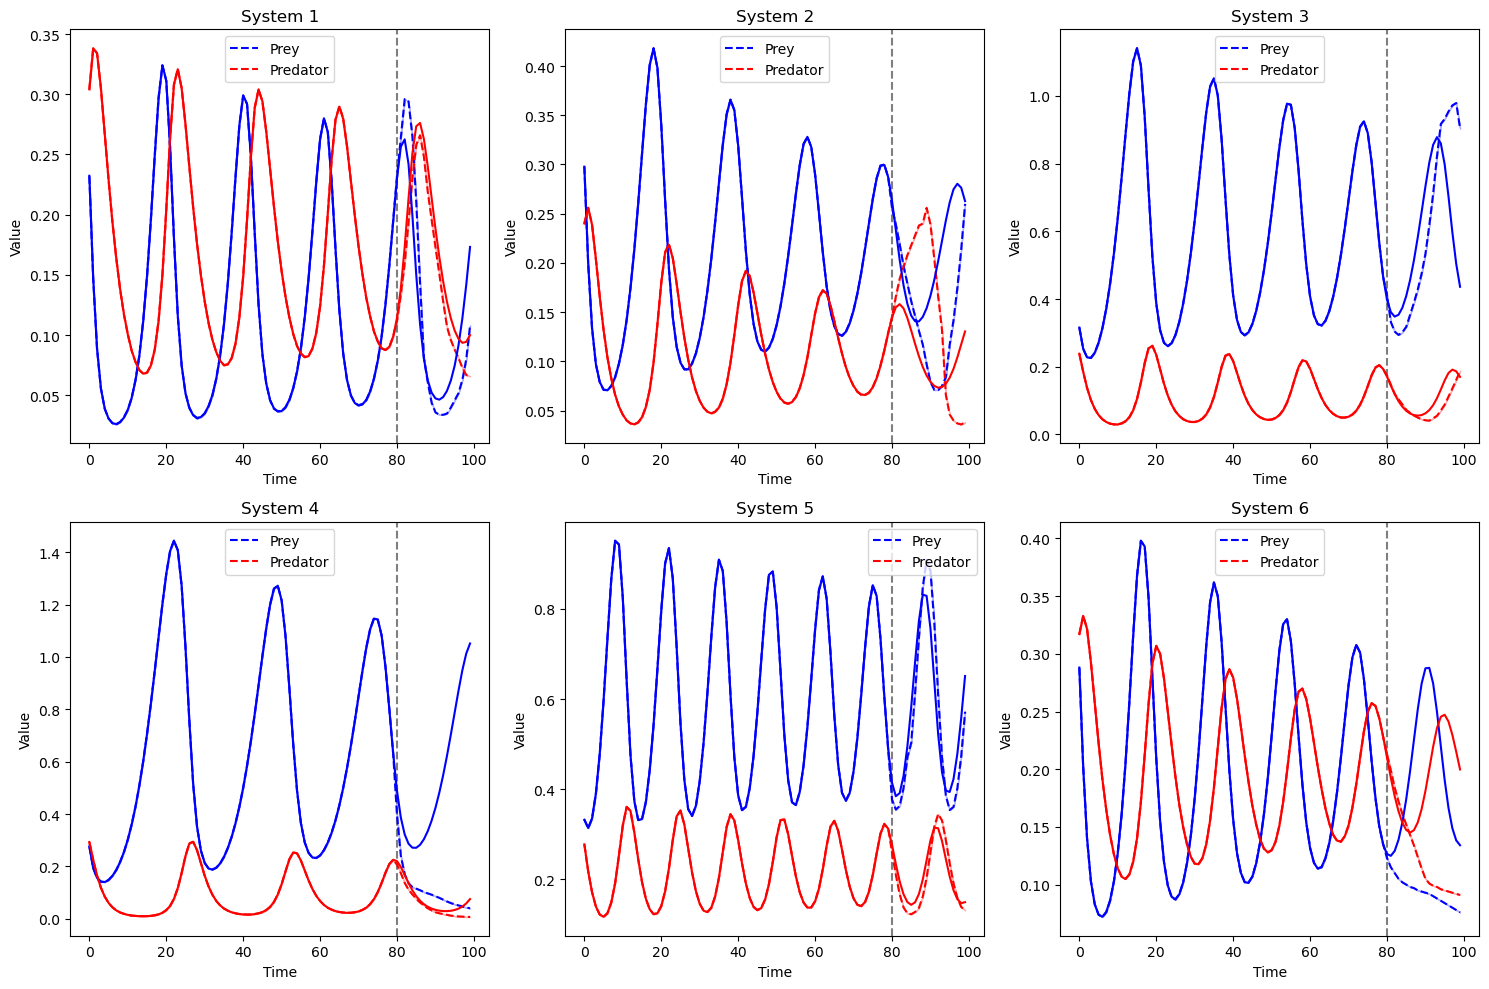

In [23]:
num_systems = 6 # Number of systems to plot
num_rows = 2
num_columns = 3

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
axes = axes.flatten()

# Loop through each system and plot on the corresponding subplot
for sys in range(num_systems):
    orig_sys= sys+900
    prey_mean = np.mean(qwen_predicted_prey[sys], axis=0)
    predator_mean = np.mean(qwen_predicted_predator[sys], axis=0)
    prey_std = np.std(qwen_predicted_prey[sys], axis=0)
    predator_std = np.std(qwen_predicted_predator[sys], axis=0)

    axes[sys].axvline(80, c='k', linestyle='--', alpha=0.5)

    axes[sys].plot(prey_mean, label="Prey", c='b', linestyle='--')
    axes[sys].fill_between(range(len(prey_mean)), prey_mean - prey_std, prey_mean + prey_std, color='b', alpha=0.3)

    axes[sys].plot(predator_mean, label="Predator", c='r', linestyle='--')
    axes[sys].fill_between(range(len(predator_mean)), predator_mean - predator_std, predator_mean + predator_std, color='r', alpha=0.3)

    axes[sys].plot(trajectories[orig_sys][:,0]/norm_factor, c='b') 
    axes[sys].plot(trajectories[orig_sys][:,1]/norm_factor, c='r')

    
    axes[sys].set_title(f'System {sys+1}')
    axes[sys].set_xlabel('Time')
    axes[sys].set_ylabel('Value')

    axes[sys].legend()
    mse_prey = mse(prey_mean[80:], trajectories[orig_sys][80:,0]/norm_factor)
    mse_predator = mse(predator_mean[80:], trajectories[orig_sys][80:,1]/norm_factor)
    print(f"System {sys+1}: Prey MSE = {mse_prey:.3f}, Predator MSE = {mse_predator:.3f}") 
  
plt.tight_layout()
total_MSE_prey, total_MSE_predator = tot_mse(qwen_predicted_prey, qwen_predicted_predator, trajectories, norm_factor)
print(f"Total MSE for prey: {total_MSE_prey:.3f}")
print(f"Total MSE for predator: {total_MSE_predator:.3f}")
plt.savefig('plots/system_forecasts.png', dpi=300)


# FLOPS


In [3]:
total_flops_untrained = FLOPS.total_flops_forward(
    num_layers = 24, 
    D = 768, 
    N = 12, 
    H = 64, 
    D_FF= 3072, 
)
print(f"Total FLOPS for untrained model: {total_flops_untrained:.2e}")

Total FLOPS for untrained model: 5.48e+09
